## Cooling Tank Model

This notebook demonstrates the optimization of the tank model described in `tank_optimization_model.py` using the `ProblemInterface` class in the `fmdtools.search` module.

Note that this problem/notebook was adapted from the identical problem here: https://github.com/DesignEngrLab/resil_opt_examples/tree/main/Cooling%20Tank%20Problem, which shows more comparisions of these architectures. 

In [1]:
import numpy as np
import time
import pandas as pd

import fmdtools.sim.propagate as propagate
import fmdtools.analyze as an
import fmdtools.sim.search as search
from tank_optimization_model import Tank
from fmdtools.define import SampleApproach
import matplotlib.pyplot as plt

# Simulation

### Verifying the nominal state:

In the nominal state, no change in system state should occurs.

In [2]:
mdl = Tank()
resgraph, mdlhist = propagate.nominal(mdl, desired_result='normal')

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

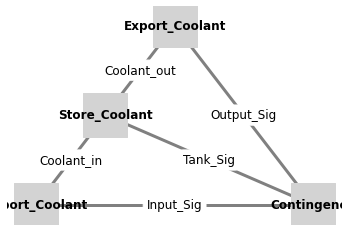

In [3]:
an.graph.show(resgraph, gtype='normal')

C:\Users\dhulse\Documents\GitHub\fmdtools\example_tank\..\fmdtools\analyze\plot.py:260: UserWarning: Deprecated function. Use analyze.plot.mdlhists instead.
  warnings.warn("Deprecated function. Use analyze.plot.mdlhists instead.")


(<Figure size 432x1728 with 24 Axes>,
 array([<AxesSubplot:title={'center':'Coolant_in: effort'}>,
        <AxesSubplot:title={'center':'Coolant_in: rate'}>,
        <AxesSubplot:title={'center':'Coolant_out: effort'}>,
        <AxesSubplot:title={'center':'Coolant_out: rate'}>,
        <AxesSubplot:title={'center':'Input_Sig: indicator'}>,
        <AxesSubplot:title={'center':'Input_Sig: action'}>,
        <AxesSubplot:title={'center':'Tank_Sig: indicator'}>,
        <AxesSubplot:title={'center':'Tank_Sig: action'}>,
        <AxesSubplot:title={'center':'Output_Sig: indicator'}>,
        <AxesSubplot:title={'center':'Output_Sig: action'}>,
        <AxesSubplot:title={'center':'Import_Coolant: faults: Leak'}>,
        <AxesSubplot:title={'center':'Import_Coolant: faults: Blockage'}>,
        <AxesSubplot:title={'center':'Import_Coolant: open'}>,
        <AxesSubplot:title={'center':'Import_Coolant: mode'}>,
        <AxesSubplot:title={'center':'Store_Coolant: faults: Leak'}>,
        <

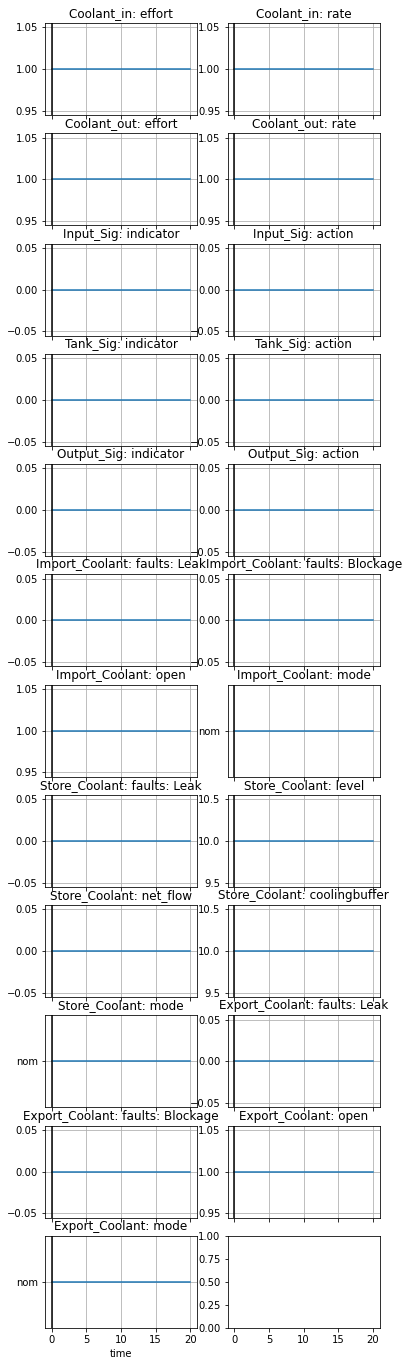

In [4]:
an.plot.mdlhistvals(mdlhist)

### What happens under component faults?


Here we model a leak of the tank. As shown, the coolant leaks until there is no more coolant left in the tank. While this results in a warning signal, the default contingency management policy is to take no actions to alleviate the condition.

C:\Users\dhulse\Documents\GitHub\fmdtools\example_tank\..\fmdtools\analyze\plot.py:260: UserWarning: Deprecated function. Use analyze.plot.mdlhists instead.
  warnings.warn("Deprecated function. Use analyze.plot.mdlhists instead.")


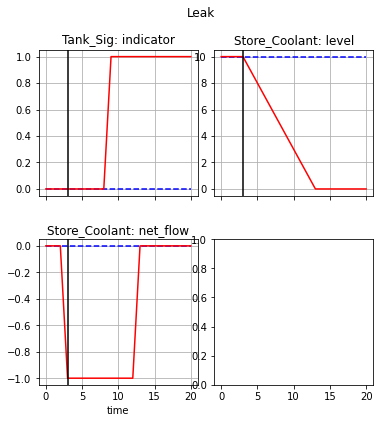

In [5]:
resgraph, mdlhist = propagate.one_fault(mdl,'Store_Coolant','Leak', time=3, gtype='normal', desired_result='normal')

fig, ax = an.plot.mdlhistvals(mdlhist, fault='Leak', time=3, fxnflowvals={'Store_Coolant':['level', 'net_flow'], 'Tank_Sig':['indicator'], 'Valve1_Sig':['action']}, legend=False) #,
#fig.axes[3].remove()
fig.set_figheight(6)
fig.set_figwidth(6)
fig.subplots_adjust(top = 0.9, wspace=0.1, hspace=0.3)

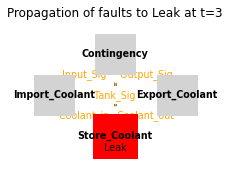

In [6]:
#add graph view to figure
import networkx as nx
graph_fig, graph_ax = an.graph.show(resgraph,faultscen='Leak', time=3, scale=0.8, gtype='normal', pos=nx.shell_layout(resgraph))
graph_ax.figure = fig
fig.axes.append(graph_ax)
fig.add_axes(graph_ax)
graph_ax.set_position([0.6,0.10,0.5,0.5])
graph_ax.margins(0.3)

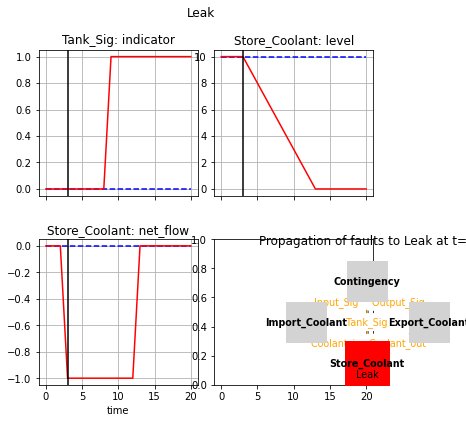

In [7]:
fig

### Full set of modes

The tank leak mode will not be the only mode considered, but also leak and blockage faults in the Imput/Output blocks.

In [8]:
app_joint_faults = SampleApproach(mdl)
endclasses, mdlhists = propagate.approach(mdl, app_joint_faults)
fmea_tab = an.tabulate.simplefmea(endclasses)
fmea_tab

SCENARIOS COMPLETE: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 201.06it/s]


,rate,cost,expected cost
"Import_Coolant Leak, t=0",0.000002,2100000.0,350000.000000
"Import_Coolant Blockage, t=0",0.000002,2100000.0,350000.000000
"Store_Coolant Leak, t=0",0.000002,1000000.0,166666.666667
"Export_Coolant Leak, t=0",0.000002,1000000.0,166666.666667
"Export_Coolant Blockage, t=0",0.000002,100000.0,16666.666667
nominal,1.000000,0.0,0.000000


In [9]:
print(fmea_tab.to_latex(float_format="%.2g"))

\begin{tabular}{lrrr}
\toprule
{} &    rate &    cost &  expected cost \\
\midrule
Import\_Coolant Leak, t=0     & 1.7e-06 & 2.1e+06 &        3.5e+05 \\
Import\_Coolant Blockage, t=0 & 1.7e-06 & 2.1e+06 &        3.5e+05 \\
Store\_Coolant Leak, t=0      & 1.7e-06 &   1e+06 &        1.7e+05 \\
Export\_Coolant Leak, t=0     & 1.7e-06 &   1e+06 &        1.7e+05 \\
Export\_Coolant Blockage, t=0 & 1.7e-06 &   1e+05 &        1.7e+04 \\
nominal                      &       1 &       0 &              0 \\
\bottomrule
\end{tabular}



### Defining Optimization Problem

We can define an optimization problem around this model using the `ProblemInterface` class.

In this case, we consider the joint minimization of design cost (defined in a function) and resilience cost (expected cost over the above list of scenarios). This is over two sets of variables

- capacity and turnup (design variables that effect both design and resilience costs), and
- the resilience policy (variables that only effect resilience cost)

In [10]:
mdl= Tank()
prob = search.ProblemInterface("res_problem", mdl, staged=True)

To model design cost (which does not involve simulation), we attach an external callable using the "external" option in `.add_simulation`. Note that this callable is defined in terms of its objective only.

In [11]:
def x_to_descost(xdes):
    pen = 0 #determining upper-level penalty
    if xdes[0]<10: pen+=1e5*(10-xdes[0])**2
    if xdes[0]>100: pen+=1e5*(100-xdes[0])**2
    if xdes[1]<0: pen+=1e5*(xdes[1])**2
    if xdes[1]>1: pen+=1e5*(1-xdes[1])**2
    return (xdes[0]-10)*1000 + (xdes[0]-10)**2*1000   + xdes[1]**2*10000 + pen
prob.add_simulation("des_cost", "external", x_to_descost)
prob.add_objectives("des_cost", cd="cd")
prob.add_variables("des_cost",'capacity', 'turnup')

In [12]:
prob

Problem res_problem                                                     current value
 Variables
 -vars capacity at t=0: None                                                      nan
 -vars turnup at t=0: None                                                        nan
 Objectives
 -cd: +(des_cost   at t=)                                                         nan
 Constraints
 -
 Simulations
 -des_cost: external scen: 

Since the design variables affect both design and resilience costs, we can use the `upstream_sims` option to translate "des_cost" variables into "res_sim" simulation parameters. 

In [13]:
app = SampleApproach(mdl)
prob.add_simulation("res_sim", "multi", app.scenlist, upstream_sims = {"des_cost":{'params':{"capacity":"capacity", "turnup":"turnup"}}})

res_vars_i = {param:1 for param,v in mdl.params.items() if param not in ['capacity','turnup']}
res_vars = [(var, None) for var in res_vars_i.keys()]
prob.add_variables("res_sim", *res_vars, vartype="param")
prob.add_objectives("res_sim", cost="expected cost", objtype="endclass")

Finally, to get a callable for both objectives, we can use `add_combined_objective`, which will perform an opteration (default is sum) to combine the objectives:

In [14]:
prob.add_combined_objective('tot_cost', 'cd', 'cost')

In [15]:
prob

Problem res_problem                                                     current value
 Variables
 -vars capacity at t=0: None                                                      nan
 -vars turnup at t=0: None                                                        nan
 -param (-1, -1, -1, 'l') at t=0: None                                            nan
 -param (-1, -1, 0, 'l') at t=0: None                                             nan
 -param (-1, -1, 1, 'l') at t=0: None                                             nan
 -param (-1, 0, -1, 'l') at t=0: None                                             nan
 -param (-1, 0, 0, 'l') at t=0: None                                              nan
 -param (-1, 0, 1, 'l') at t=0: None                                              nan
 -param (-1, 1, -1, 'l') at t=0: None                                             nan
 -param (-1, 1, 0, 'l') at t=0: None                                              nan
 -param (-1, 1, 1, 'l') at t=0: None       

Note that because the simulations are linked, changes to xdes in the `cd` function in turn change the lower-level `cost` function by default.

In [16]:
xdes = [1,2]
prob.cd(xdes)

8312000.0

In [17]:
prob.cost([*res_vars_i.values()])

4001383333.3333335

In [18]:
xdes = [1,3]
prob.cd(xdes)

8662000.0

In [19]:
prob.cost([*res_vars_i.values()])

4001366666.6666665

These costs can be treated as independent by clearing the problem prior to the lower-level cost evalutation.

In [20]:
prob.clear()
prob.update_sim_vars("res_sim", newparams={'capacity':1, 'turnup':2})
prob.cost([*res_vars_i.values()])

4001383333.3333335

### Optimization

This problem is optimized here using four different architectures, following the example in:

Hulse, D., & Hoyle, C. (2022). Understanding Resilience Optimization Architectures: Alignment and Coupling in Multilevel Decomposition Strategies. Journal of Mechanical Design, 144(11), 111704.

The implementation of these architectures is provided in `tank_opt` using the `ProblemInterface` class. Here we show some results for comparing the architectures, which as shown are consistent with the reference.

In [21]:
import importlib
import tank_opt
import multiprocessing as mp
importlib.reload(tank_opt)
pool = mp.Pool(5)

alternating optimization structure

In [22]:
result_alt, llargs_alt, fhist_alt, thist_alt, xdhist_alt = tank_opt.alternating_opt(pool=pool)

[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.05   0.475]
[22.0171875   0.48164062]
[22.00078125  0.45996094]
[22.00078125  0.45996094]
[22.00078125  0.45996094]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00283203  0.4501709 ]
[22.00071716  0.45401688]
[22.00376129  0.43635979]
[22.00105362  0.4352232 ]
[22.00578804  0.39934072]
[22.00273991  0.37912631]
[22.01068468  0.29725416]
[22.0085608   0.21588925]
[2.20233884e+01 1.14624918e-02]
[22.02126453  0.        ]
[22.01544363  0.11081025]
[22.00828543  0.14329039]
[22.00828543  0.14329039]
[22.00638767  0.08860283]
[22.00638767  0.08860283]
[22.00638767  0.08860283]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[2.20007596e+01 6.00495249e-03]
[22.00024225  0.        ]
[22.00024225  0.        ]
[2.20001588e+01 4.50371437e-03

['iter 31: ', 278333.3333333333]
['iter 32: ', 278333.3333333333]
['iter 33: ', 278333.3333333333]
['iter 34: ', 278333.3333333333]
['iter 35: ', 278333.3333333333]
['iter 36: ', 278333.3333333333]
['iter 37: ', 278333.3333333333]
['iter 38: ', 278333.3333333333]
['iter 39: ', 278333.3333333333]
['iter 40: ', 278333.3333333333]
['iter 41: ', 278333.3333333333]
['iter 42: ', 278333.3333333333]
['iter 43: ', 278333.3333333333]
['iter 44: ', 278333.3333333333]
['iter 45: ', 278333.3333333333]
['iter 46: ', 278333.3333333333]
['iter 47: ', 278333.3333333333]
['iter 48: ', 278333.3333333333]
['iter 49: ', 278333.3333333333]
['iter 50: ', 278333.3333333333]
['iter 51: ', 278333.3333333333]
['iter 52: ', 278333.3333333333]
['iter 53: ', 278333.3333333333]
['iter 54: ', 278333.3333333333]
['iter 55: ', 278333.3333333333]
['iter 56: ', 278333.3333333333]
['iter 57: ', 278333.3333333333]
['iter 58: ', 278333.3333333333]
['iter 59: ', 278333.3333333333]
['iter 60: ', 278333.3333333333]
['iter 61:

[20.0078125  0.       ]
[20.0078125  0.       ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00390625  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00195312  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00097656  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00048828  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00024414  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00012207  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00006104  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00003052  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00001526  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000763  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000381  0.        ]
[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000191  0.        ]
[20.00000095  0.

['iter 31: ', 344166.6666666666]
['iter 32: ', 344166.6666666666]
['iter 33: ', 344166.6666666666]
['iter 34: ', 344166.6666666666]
['iter 35: ', 344166.6666666666]
['iter 36: ', 344166.6666666666]
['iter 37: ', 344166.6666666666]
['iter 38: ', 344166.6666666666]
['iter 39: ', 344166.6666666666]
['iter 40: ', 344166.6666666666]
['iter 41: ', 344166.6666666666]
['iter 42: ', 344166.6666666666]
['iter 43: ', 344166.6666666666]
['iter 44: ', 344166.6666666666]
['iter 45: ', 344166.6666666666]
['iter 46: ', 344166.6666666666]
['iter 47: ', 344166.6666666666]
['iter 48: ', 344166.6666666666]
['iter 49: ', 344166.6666666666]
['iter 50: ', 344166.6666666666]
['iter 51: ', 344166.6666666666]
['iter 52: ', 344166.6666666666]
['iter 53: ', 344166.6666666666]
['iter 54: ', 344166.6666666666]
['iter 55: ', 344166.6666666666]
['iter 56: ', 344166.6666666666]
['iter 57: ', 344166.6666666666]
['iter 58: ', 344166.6666666666]
['iter 59: ', 344166.6666666666]
['iter 60: ', 344166.6666666666]
['iter 61:

In [23]:
result_alt.fun

454166.6668231288

In [24]:
result_alt_nocr, llargs_alt_nocr, fhist_alt_nocr, thist_alt_nocr, xdhist_alt_nocr = tank_opt.alternating_opt(option="without_cr",pool=pool)

[18.9     0.5375]
[17.85     0.50625]
[13.125     0.565625]
[10.         0.5328125]
[10.         0.5328125]
[10.         0.5328125]
[10.          0.45390625]
[10.          0.36132812]
[10.          0.15722656]
[10.  0.]
[10.  0.]
[10.  0.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 24
['iter 0: ', 903333.3333333333]
['iter 1: ', 903333.3333333333]
['iter 2: ', 903333.3333333333]
['iter 3: ', 903333.3333333333]
['iter 4: ', 903333.3333333333]
['iter 5: ', 903333.3333333331]
['iter 6: ', 903333.3333333331]
['iter 7: ', 903333.3333333331]
['iter 8: ', 899999.9999999999]
['iter 9: ', 899999.9999999999]
['iter 10: ', 899999.9999999999]
['iter 11: ', 899999.9999999999]
['iter 12: ', 899999.9999999999]
['iter 13: ', 899999.9999999999]
['iter 14: ', 899999.9999999999]
['iter 15: ', 899999.9999999999]
['iter 16: ', 899999.9999999999]
['iter 17: ', 899999.9999999999]
['iter 18: ', 899999.9999999999]
['ite

['iter 26: ', 893333.3333333333]
['iter 27: ', 893333.3333333333]
['iter 28: ', 893333.3333333333]
['iter 29: ', 893333.3333333333]
['iter 30: ', 893333.3333333333]
['iter 31: ', 893333.3333333333]
['iter 32: ', 893333.3333333333]
['iter 33: ', 893333.3333333333]
['iter 34: ', 893333.3333333333]
['iter 35: ', 893333.3333333333]
['iter 36: ', 893333.3333333333]
['iter 37: ', 893333.3333333333]
['iter 38: ', 893333.3333333333]
['iter 39: ', 893333.3333333333]
['iter 40: ', 893333.3333333333]
['iter 41: ', 893333.3333333333]
['iter 42: ', 893333.3333333333]
['iter 43: ', 893333.3333333333]
['iter 44: ', 893333.3333333333]
['iter 45: ', 893333.3333333333]
['iter 46: ', 893333.3333333333]
['iter 47: ', 893333.3333333333]
['iter 48: ', 893333.3333333333]
['iter 49: ', 893333.3333333333]
['iter 50: ', 893333.3333333333]
['iter 51: ', 893333.3333333333]
['iter 52: ', 893333.3333333333]
['iter 53: ', 893333.3333333333]
['iter 54: ', 893333.3333333333]
['iter 55: ', 893333.3333333333]
['iter 56:

In [25]:
result_bi, llargs_bi, bestf_bi, bestxdes_bi = tank_opt.bilevel_opt(pool=pool)

time: 9.608155488967896 fval: 337000.0 xdes: [21.   0.5]
time: 17.859375715255737 fval: 326419.1666666667 xdes: [22.05  0.5 ]
time: 26.792043447494507 fval: 317756.25 xdes: [21.     0.525]
time: 35.68012261390686 fval: 325675.4166666666 xdes: [22.05   0.525]
[21.     0.525]
time: 44.36492419242859 fval: 317191.6666666666 xdes: [21.    0.55]
time: 53.39910864830017 fval: 305173.5416666664 xdes: [20.475  0.575]
[20.475  0.575]
time: 61.73811340332031 fval: 304895.20833333314 xdes: [19.425  0.575]
time: 70.25829339027405 fval: 295691.8229166664 xdes: [18.1125  0.6   ]
[18.1125  0.6   ]
time: 78.90931439399719 fval: 320715.9895833328 xdes: [17.5875  0.65  ]
time: 87.64331293106079 fval: 301200.0878906249 xdes: [20.146875  0.55625 ]
[18.1125  0.6   ]
time: 96.37678980827332 fval: 339926.0514322915 xdes: [17.784375  0.58125 ]
time: 107.00541043281555 fval: 310879.196573893 xdes: [19.80234375  0.5765625 ]
time: 115.9667432308197 fval: 300323.166503906 xdes: [19.1296875  0.578125 ]
time: 124.3

time: 955.7078990936279 fval: 279239.6864227174 xdes: [18.40063721  0.60013973]
[18.40063721  0.60013973]
time: 963.9815261363983 fval: 279238.9942135684 xdes: [18.40061059  0.60012155]
time: 972.3542585372925 fval: 279237.9268906699 xdes: [18.40055597  0.60011363]
[18.40055597  0.60011363]
time: 980.6095764636993 fval: 293403.8433247941 xdes: [18.40049999  0.60013415]
time: 988.754138469696 fval: 279239.62165836344 xdes: [18.40064489  0.60012294]
[18.40055597  0.60011363]
time: 997.0824129581451 fval: 279237.8621338353 xdes: [18.40056365  0.60009684]
time: 1005.5536546707153 fval: 279236.9500072551 xdes: [18.40052688  0.60007539]
[18.40052688  0.60007539]
time: 1014.002151966095 fval: 279235.2552694144 xdes: [18.40043795  0.60006607]
time: 1022.3566646575928 fval: 279233.0721313214 xdes: [18.40033448  0.60003763]
[18.40033448  0.60003763]
time: 1031.4231617450714 fval: 279232.09531891905 xdes: [18.40030539  0.59999939]
time: 1039.6561887264252 fval: 293395.84634468233 xdes: [18.400180

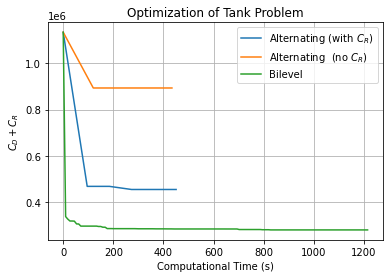

In [26]:
fig = plt.figure()
fhist_alt_plot = [min(fhist_alt[:f+1]) for f,_ in enumerate(fhist_alt)]
plt.plot(thist_alt, fhist_alt_plot, label="Alternating (with $C_R$)")

fhist_alt_nocr_plot = [min(fhist_alt_nocr[:f+1]) for f,_ in enumerate(fhist_alt_nocr)]
plt.plot(thist_alt_nocr, fhist_alt_nocr_plot, label="Alternating  (no $C_R$)")

thist_bilevel_plot = [0]+llargs_bi['thist']
fhist_bilevel_plot = [fhist_alt[0]]+llargs_bi['fhist']
fhist_bilevel_plot = [min(fhist_bilevel_plot[:f+1]) for f,_ in enumerate(fhist_bilevel_plot)]
plt.plot(thist_bilevel_plot, fhist_bilevel_plot, label="Bilevel")
#plt.plot(t, [fhist_alt[0]]+llargs_bi['fhist'], label="Bilevel")
plt.title("Optimization of Tank Problem")
plt.grid()
plt.ylabel("$C_D+C_R$")
#plt.yscale("log")
plt.xlabel("Computational Time (s)")
plt.legend()

In [27]:
fig.savefig('tank_optimization.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

In [28]:
tab = pd.DataFrame(columns = ["$x_t$", "$x_l$", "$f^*$", "time"])
tab.loc['Bilevel'] = list(result_bi['x']) +  [result_bi['fun'], llargs_bi['thist'][-1]]
tab.loc['Alt. (no $C_R$)'] = list(result_alt_nocr['x']) + [llargs_alt_nocr['ll_opt'], thist_alt_nocr[-1]]
tab.loc['Alt. (with $C_R$)'] = list(result_alt['x']) + [result_alt['fun'], thist_alt[-1]]
tab.loc['Seq. (with $C_R$)'] = list(xdhist_alt[1]) + [fhist_alt[1], thist_alt[1]]
tab.loc['Seq. (no $C_R$)'] = list(xdhist_alt_nocr[1]) + [fhist_alt_nocr[1], thist_alt_nocr[1]]

In [29]:
tab

,$x_t$,$x_l$,$f^*$,time
Bilevel,18.400204,0.599967,279229.896067,1215.097399
Alt. (no $C_R$),10.000000,0.000000,893333.333333,434.063679
Alt. (with $C_R$),20.000000,0.000000,454166.666823,450.757209
Seq. (with $C_R$),22.000000,0.000000,467666.666722,95.740538
Seq. (no $C_R$),10.000000,0.000000,893333.333333,120.030809


Note that these are the previously-recorded results:

|               |    𝑥_t      |   𝑥_l   |       𝑓     |    time     |
|--------------------|----------:|---------:|--------------:|------------|
|            Bilevel | 18.000015 | 0.580982 | 285708.991759 | 619.369699 |
|   Alt. (no  𝐶 𝑅CR) | 10.000000 | 0.000000 | 893333.333333 | 168.275383 |
| Alt. (with  𝐶 𝑅CR) | 20.000000 | 0.000000 | 452666.666823 | 306.776320 |
| Seq. (with  𝐶 𝑅CR) | 22.000000 | 0.000000 | 466333.333389 |  61.702104 |
|   Seq. (no  𝐶 𝑅CR) | 10.000000 | 0.000000 | 893333.333333 |  55.957946 |

As shown, the results are consistent (not exactly, since the lower-level EA is a stochastic search), and this problem gives better results from a bilevel search as expected. However, the optimization is somewhat slower, so it may (still) be helpful to implement interfaces manually to avoid some model instantiation overhead.